In [27]:
import instaloader
import tensorflow as tf
from tensorflow import keras
import os
# https://instaloader.github.io/index.html

In [10]:
# Download all the pictures to local
!instaloader profile virgo_n_kuma

JSON Query to profile/: 404 Not Found [retrying; skip with ^C]
JSON Query to profile/: 404 Not Found [retrying; skip with ^C]
profile: Profile profile does not exist.
The most similar profiles are: profile_set_, profileworld, photo_de_profile_tv, profile_wall, profile.set.
virgo_n_kuma/2019-05-14_15-43-23_UTC_profile_pic.jpg already exists

Errors occured:
profile: Profile profile does not exist.
The most similar profiles are: profile_set_, profileworld, photo_de_profile_tv, profile_wall, profile.set.


In [ ]:
# step 1
filenames = tf.constant(['im_01.jpg', 'im_02.jpg', 'im_03.jpg', 'im_04.jpg'])
labels = tf.constant([0, 1, 0, 1])

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# step 3: parse every image in the dataset using `map`
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)
dataset = dataset.batch(2)

# step 4: create iterator and final input tensor
iterator = dataset.make_one_shot_iterator()
images, labels = iterator.get_next()

In [24]:
# Dataset Parameters - CHANGE HERE
MODE = 'folder' # or 'file', if you choose a plain text file (see above).
DATASET_PATH = 'virgo_n_kuma/' # the dataset file or root folder path.

# Image Parameters
IMG_HEIGHT = 224 # CHANGE HERE, the image height to be resized to
IMG_WIDTH = 224 # CHANGE HERE, the image width to be resized to
CHANNELS = 3 # The 3 color channels, change to 1 if grayscale

In [116]:
# Reading the dataset
# 2 modes: 'file' or 'folder'
def read_images(dataset_path, mode):
    imagepaths, labels = list(), list()
    if mode == 'file':
        # Read dataset file
        data = open(dataset_path, 'r').read().splitlines()
        for d in data:
            imagepaths.append(d.split(' ')[0])
            labels.append(int(d.split(' ')[1]))
    elif mode == 'folder':
        # An ID will be affected to each sub-folders by alphabetical order
        label = 0
        # List the directory
        try:  # Python 2
            classes = sorted(os.walk(dataset_path).next()[1])
        except Exception:  # Python 3
            classes = sorted(os.walk(dataset_path).__next__()[1])
            
        # List each sub-directory (the classes)
        for c in classes:
            c_dir = os.path.join(dataset_path, c)
            try:  # Python 2
                walk = os.walk(c_dir).next()
            except Exception:  # Python 3
                walk = os.walk(c_dir).__next__()
            # Add each image to the training set
            for sample in walk[2]:
                # Only keeps jpeg images
                if sample.endswith('.jpg') or sample.endswith('.jpeg'):
                    imagepaths.append(os.path.join(c_dir, sample))
                    labels.append(label)
            label += 1
    else:
        raise Exception("Unknown mode.")

#     # Convert to Tensor
#     imagepaths = tf.convert_to_tensor(imagepaths, dtype=tf.string)
#     labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    
#     # Build a TF Queue
#     image = tf.data.Dataset.from_tensor_slices(imagepaths)
#     label = tf.data.Dataset.from_tensor_slices(labels)

    # Read images from disk
    X, Y = [], []
    for elem, lab in zip(imagepaths, labels):
        image = tf.io.read_file(elem)
        image = tf.image.decode_jpeg(image, channels=CHANNELS)

        # Resize images to a common size
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

        # Normalize
        image = image * 1.0/255
        X.append(image)
        Y.append(lab)

    return (X, Y)

In [194]:
X, Y = read_images(DATASET_PATH, MODE)

In [118]:
sum(Y)/len(Y)

<tf.Tensor: shape=(), dtype=float64, numpy=0.14583333333333334>

In [171]:
from sklearn.model_selection import train_test_split

# X = [keras.applications.xception.preprocess_input(x) for x in X]

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, stratify=Y)

In [146]:
n_classes = 2
batch_size = 32

base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [173]:
# Freeze the weight for the pretrained model
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam(lr=0.2, beta_1=0.9, beta_2=0.999)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(tf.stack(X_train), tf.stack(y_train), epochs=5, validation_data=(tf.stack(X_valid), tf.stack(y_valid)))

Train on 72 samples, validate on 24 samples
Epoch 1/5
72/72 [==============================] - 6s 79ms/sample - loss: 7.6380 - accuracy: 0.5000 - val_loss: 7.6356 - val_accuracy: 0.5000
Epoch 2/5
72/72 [==============================] - 4s 53ms/sample - loss: 7.6380 - accuracy: 0.5000 - val_loss: 7.6356 - val_accuracy: 0.5000
Epoch 3/5
72/72 [==============================] - 4s 54ms/sample - loss: 7.6380 - accuracy: 0.5000 - val_loss: 7.6356 - val_accuracy: 0.5000
Epoch 4/5
72/72 [==============================] - 4s 53ms/sample - loss: 7.6380 - accuracy: 0.5000 - val_loss: 7.6356 - val_accuracy: 0.5000
Epoch 5/5
72/72 [==============================] - 4s 53ms/sample - loss: 7.6380 - accuracy: 0.5000 - val_loss: 7.6356 - val_accuracy: 0.5000


In [174]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(tf.stack(X_train), tf.stack(y_train), epochs=4, validation_data=(tf.stack(X_valid), tf.stack(y_valid)))

Train on 72 samples, validate on 24 samples
Epoch 1/4
72/72 [==============================] - 16s 220ms/sample - loss: 7.6380 - accuracy: 0.5000 - val_loss: 7.6356 - val_accuracy: 0.5000
Epoch 2/4
72/72 [==============================] - 13s 174ms/sample - loss: 7.6380 - accuracy: 0.5000 - val_loss: 7.6356 - val_accuracy: 0.5000
Epoch 3/4
72/72 [==============================] - 13s 175ms/sample - loss: 7.6380 - accuracy: 0.5000 - val_loss: 7.6356 - val_accuracy: 0.5000
Epoch 4/4
72/72 [==============================] - 13s 178ms/sample - loss: 7.6380 - accuracy: 0.5000 - val_loss: 7.6356 - val_accuracy: 0.5000


In [167]:
tf.stack(y_train)

<tf.Tensor: shape=(72,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)>

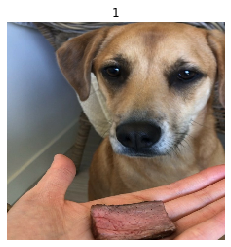

In [200]:
# Display the original picture
import matplotlib.pyplot as plt
def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy())
    plt.axis('off')

show(X_train[7], y_train[7])